In [2]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from datetime import datetime
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.interpolate
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
import RunData
from RunData import PCA

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

# No priors

Apr07.PCAplot.0


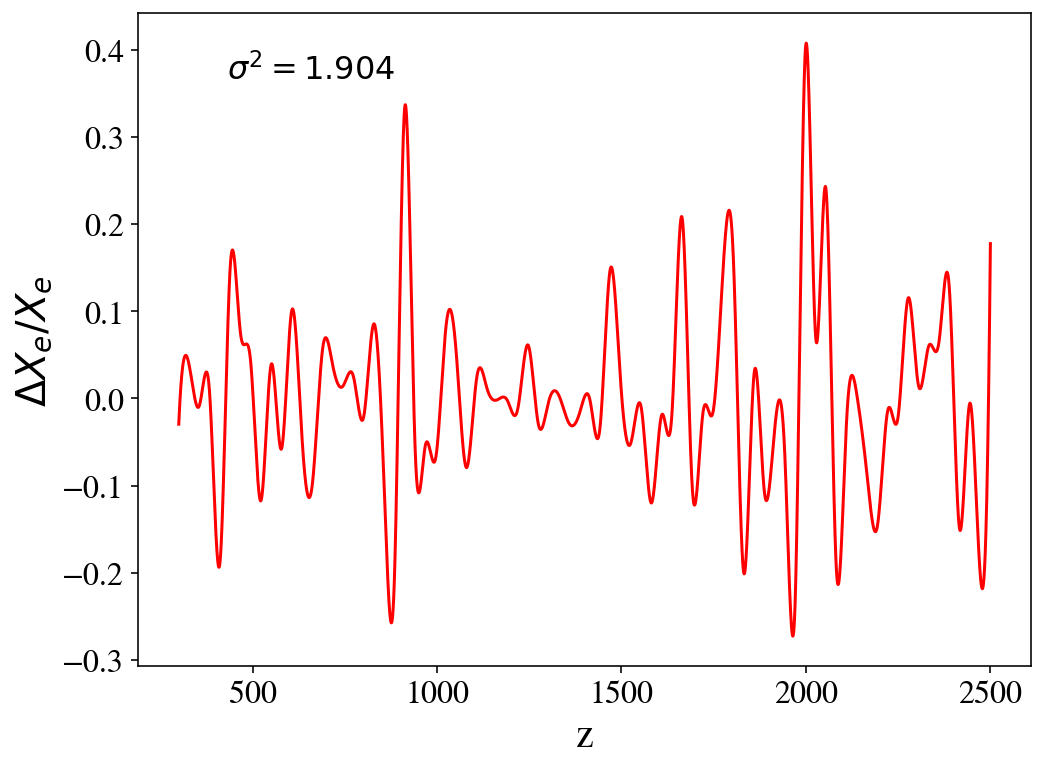

In [24]:
basedir = "/Users/gabe/projects/recombination/data"

key = "PCAplot"
all_data={}
for filename in os.listdir(basedir):
    if(key in filename):
        all_data[filename] =  RunData.RunData(os.path.join(basedir, filename))
        
for key in all_data.keys():
    print(key)
        
data = all_data["Apr07.PCAplot.0"]

fsize=20

Fisher = data.Fisher.copy()

divider = 5

standard_block = Fisher[:divider, :divider]
cross_block = Fisher[:divider, divider:]
perturbation_block = Fisher[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
sig2 = 1./(F_00-num)

norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
mode*=1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(data.pivots, mode)
zs = np.linspace(data.zmin, data.zmax, 10000)

fig,ax=plt.subplots()
ax.plot(zs, fun(zs), color='r')

ax.set_xlabel("z", fontsize=fsize)
ax.set_ylabel("$\Delta X_e/X_e$", fontsize=fsize)

ax.text(0.1, 0.9, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)

fun_np = fun
#plt.savefig("../results/H0_mode_no_prior_talk.png", dpi=300, bbox_inches='tight')

# With priors (single)

(86, 86)


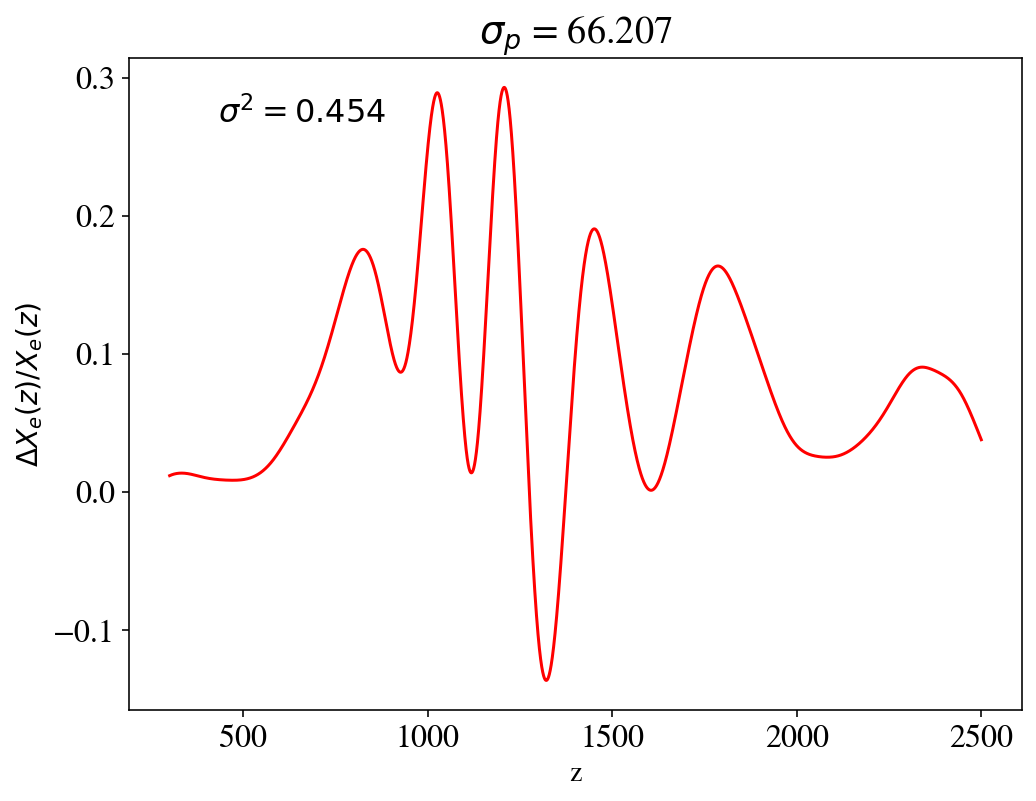

In [71]:
Fisher = data.Fisher.copy()

print(Fisher.shape)
Npert = int(data.Npert)

Fprior_block = np.zeros((Npert,Npert))

#sig_prior = 2*data.dz
sig_prior = 66.207
#sig_prior = 850
#sig_prior = 75.160371
#sig_prior=76

for i in np.arange(Npert):
    for j in np.arange(Npert):
        #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
        Fprior_block[i,j] = np.exp(-(data.pivots[i]-data.pivots[j])**2/sig_prior**2)


Fprior_block = np.linalg.pinv(Fprior_block)
Fprior = np.zeros(Fisher.shape)
Fprior[6:, 6:] = Fprior_block

Fisher+=Fprior

####################
# Calculating the mode
#
#####################
divider = 5

standard_block = Fisher[:divider, :divider]
cross_block = Fisher[:divider, divider:]
perturbation_block = Fisher[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
sig2 = 1./(F_00-num)

norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
mode *= 1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(data.pivots, mode)
zs = np.linspace(data.zmin, data.zmax, 10000)

fig,ax=plt.subplots()
ax.plot(zs, fun(zs), color='r')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel("$\Delta X_e(z)/X_e(z)$", fontsize=14)
ax.set_title("$\sigma_p$ = {}".format(sig_prior))

ax.text(0.1, 0.9, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)

fun_mp = fun 

#plt.savefig("../results/H0_mode_prior_max.pdf", dpi=300, bbox_inches='tight')

## sigma(H0) is a monotonic function

In [65]:
#prior_sigmas = np.logspace(0, 2, 100)
prior_sigmas = np.linspace(1, 100, 1000)

H0_sigmas = []

for sig_prior in prior_sigmas:
    Fisher = data.Fisher.copy()
    Fprior_block = np.zeros((Npert,Npert))
    
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
            Fprior_block[i,j] = np.exp(-(data.pivots[i]-data.pivots[j])**2/sig_prior**2)


    Fprior_block = np.linalg.pinv(Fprior_block)

    Fprior = np.zeros(Fisher.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher+=Fprior

    ####################
    # Calculating the mode
    #####################
    divider = 5

    standard_block = Fisher[:divider, :divider]
    cross_block = Fisher[:divider, divider:]
    perturbation_block = Fisher[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)
    H0_sigmas.append(sig2)

H0_sigmas = np.array(H0_sigmas)

Max is σ_H0=0.45399188931630646 at σ_prior=66.2072072072072
0.6737892024337482
2.4075348075348075


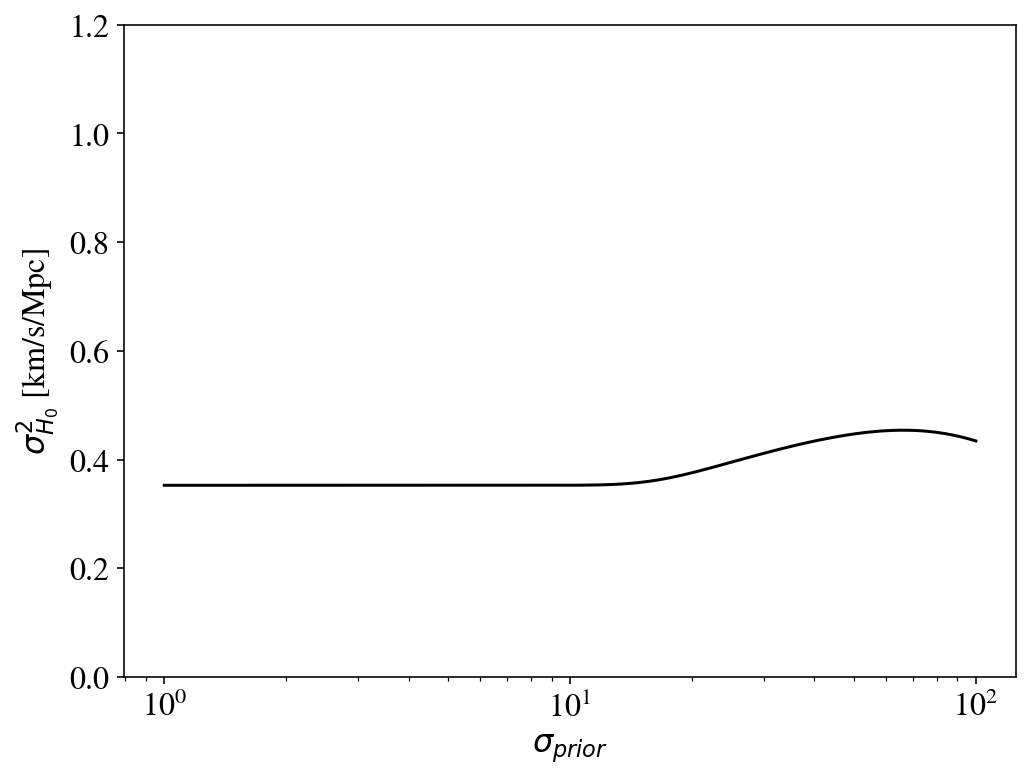

In [68]:
fig, ax = plt.subplots()
print("Max is σ_H0={} at σ_prior={}".format(np.max(H0_sigmas), prior_sigmas[np.argmax(H0_sigmas)]))
ax.plot(prior_sigmas, H0_sigmas, color='k')
#ax.plot(prior_sigmas, derivative[idx]*(prior_sigmas-prior_sigmas[idx])+H0_sigmas[idx])
ax.set_ylim([0.00, 1.2])
ax.set_xlabel("$\sigma_{prior}$")
ax.set_ylabel("$\sigma^2_{H_0}$ [km/s/Mpc]")
ax.set_xscale('log')

print(np.sqrt(np.max(H0_sigmas)))
print(prior_sigmas[np.argmax(H0_sigmas)]/data.dz)

#plt.savefig("../results/sigma_h0_dependency.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Collecting into a single cell

In [32]:
import scipy.integrate

prior_list = np.logspace(-4,np.log10(2.7),100)*data.dz
print(prior_list)
output_dict={}
H0_sig = {}

def apply_norm(norm):
    def dec(f):
        def wrapper(*args, **kwargs):
            return f(*args, **kwargs)/norm
        return wrapper
    return dec

for sig_prior in prior_list:
    ################################
    # Calculate Fisher matrix
    ################################
    #print("σ_prior={}".format(sig_prior))
    Fisher = data.Fisher.copy()

    ################################
    # Adding a smoothness prior
    ################################

    Fprior_block = np.zeros((Npert,Npert))

    #sig_prior = 1*dz
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
            Fprior_block[i,j] = np.exp(-(data.pivots[i]-data.pivots[j])**2/sig_prior**2)


    Fprior_block = np.linalg.pinv(Fprior_block)

    Fprior = np.zeros(Fisher.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher+=Fprior

    ####################
    # Calculating the mode
    #
    #####################
    divider = 5

    standard_block = Fisher[:divider, :divider]
    cross_block = Fisher[:divider, divider:]
    perturbation_block = Fisher[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)
    
    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)
    H0_sig.update({sig_prior:np.sqrt(sig2)})

    #norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
    mode*=1./np.sqrt(2*np.pi*data.width**2)

    Id = np.diag([1.]*binv.shape[0])

    #norm = np.einsum("i,ij,jk,kl,l", H0_row.T, binv, Id, binv, H0_row)
    norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
    mode*=1./np.sqrt(norm)

    #mode*=1./np.sqrt(norm)

    fun = scipy.interpolate.CubicSpline(data.pivots, mode)

    output_dict.update({sig_prior: fun})


[2.75000000e-03 3.04855436e-03 3.37952135e-03 3.74641984e-03
 4.15315074e-03 4.60403848e-03 5.10387694e-03 5.65798048e-03
 6.27224039e-03 6.95318757e-03 7.70806193e-03 8.54488939e-03
 9.47256721e-03 1.05009586e-02 1.16409975e-02 1.29048050e-02
 1.43058180e-02 1.58589323e-02 1.75806609e-02 1.94893092e-02
 2.16051704e-02 2.39507406e-02 2.65509581e-02 2.94334688e-02
 3.26289199e-02 3.61712858e-02 4.00982295e-02 4.44515028e-02
 4.92773901e-02 5.46272009e-02 6.05578152e-02 6.71322879e-02
 7.44205197e-02 8.25000000e-02 9.14566309e-02 1.01385640e-01
 1.12392595e-01 1.24594522e-01 1.38121154e-01 1.53116308e-01
 1.69739414e-01 1.88167212e-01 2.08595627e-01 2.31241858e-01
 2.56346682e-01 2.84177016e-01 3.15028758e-01 3.49229925e-01
 3.87144150e-01 4.29174541e-01 4.75767970e-01 5.27419826e-01
 5.84679277e-01 6.48155113e-01 7.18522218e-01 7.96528742e-01
 8.83004063e-01 9.78867596e-01 1.08513857e+00 1.20294689e+00
 1.33354508e+00 1.47832170e+00 1.63881603e+00 1.81673446e+00
 2.01396864e+00 2.232615

Text(0.5, 0, 'z')

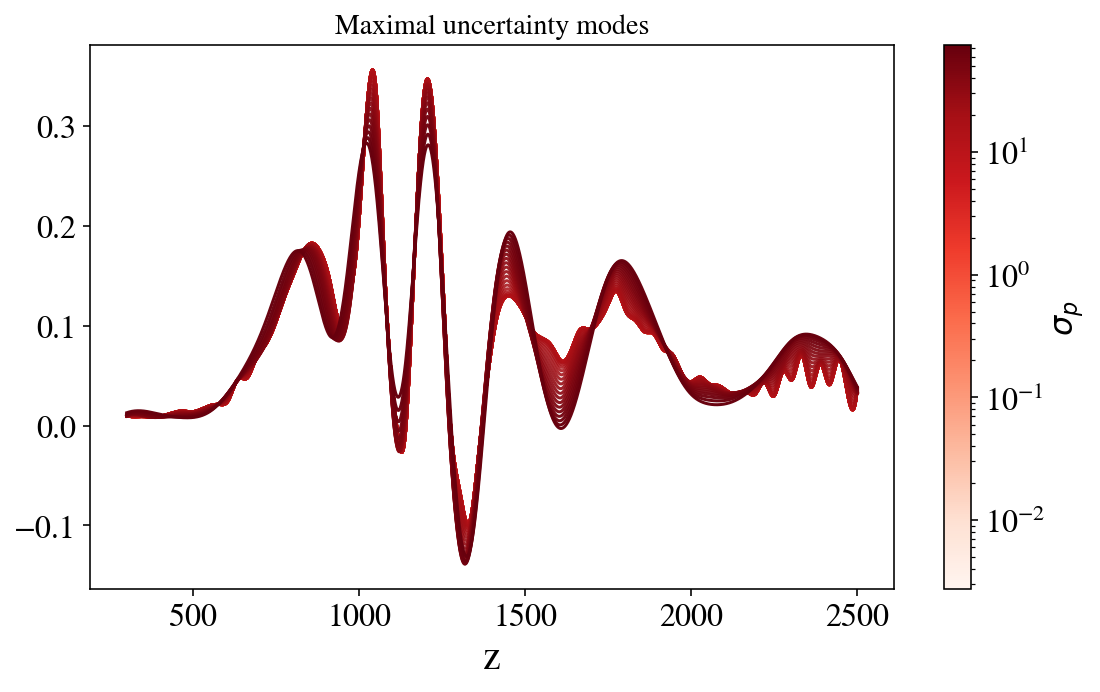

In [33]:
import matplotlib as mpl
import cycler
n = len(output_dict)
my_cm = plt.cm.Reds
color = my_cm(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

zs = np.linspace(data.zmin, data.zmax, 10000)  
fig,ax=plt.subplots(figsize=(9,5))
i=0
for sig, fun in output_dict.items():
    #ax.plot(zs, fun(zs), color="k", alpha=i/(len(output_dict)), label="$\sigma = {}$".format(sig))
    ax.plot(zs, fun(zs), alpha=i/n, label="$\sigma = {}$".format(sig))
    i+=1

sm = plt.cm.ScalarMappable(cmap=my_cm, norm=LogNorm(vmin=prior_list[0], vmax=prior_list[-1]))
cbar = plt.colorbar(sm, label="$\sigma_p$")
    
ax.set_title(r"Maximal uncertainty modes".format(sig_prior), fontsize=14)
ax.set_xlabel("z", fontsize=fsize)
#ax.axvline(1100, color='k')
#ax.axvline(1800, color='k')
#ax.text(0.15, 0.85, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)
#plt.legend()
#plt.show()

#plt.savefig("../results/H0_mode_sigprior_dependence.png", dpi=300, bbox_inches='tight')

## Projecting onto principal components

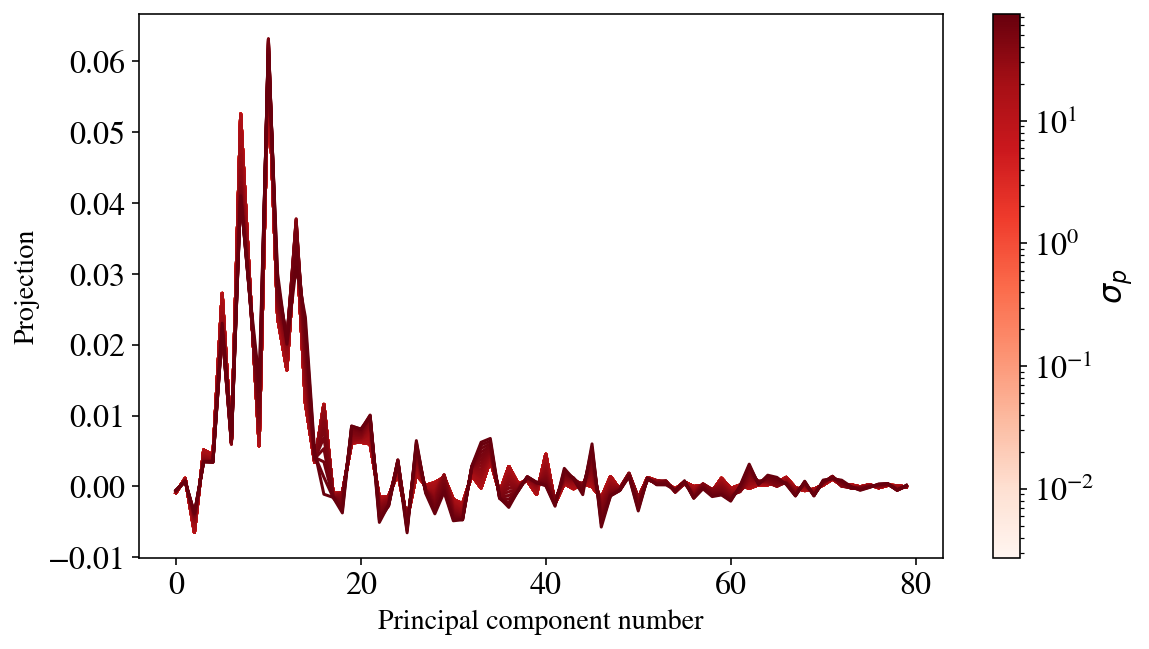

In [36]:
pca = PCA(data, fisher='m')
exem_matrix = pca.eigenvecs

n = len(output_dict)
my_cm = plt.cm.Reds
colorc = my_cm(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', colorc)

fig,ax=plt.subplots(figsize=(9,5))
i=0
for sig, fun in output_dict.items():
    #if i==0 or i==len(output_dict)-1:
        #print(sig)
    projection = np.einsum("ij,j->i", exem_matrix, fun(data.pivots))
    ax.plot(np.arange(int(data.Npert)), projection, label="$\sigma_p={}$".format(sig))
        #ax.scatter(np.arange(Npert), projection, label="$\sigma={}$".format(sig))
    i+=1


sm = plt.cm.ScalarMappable(cmap=my_cm, norm=LogNorm(vmin=prior_list[0], vmax=prior_list[-1]))
cbar = plt.colorbar(sm, label="$\sigma_p$")
ax.set_xlabel("Principal component number", fontsize=14)
ax.set_ylabel("Projection", fontsize=14)

#plt.legend()
plt.savefig("../results/H0_mode_sigprior_projections.png", dpi=300, bbox_inches='tight')
plt.show()

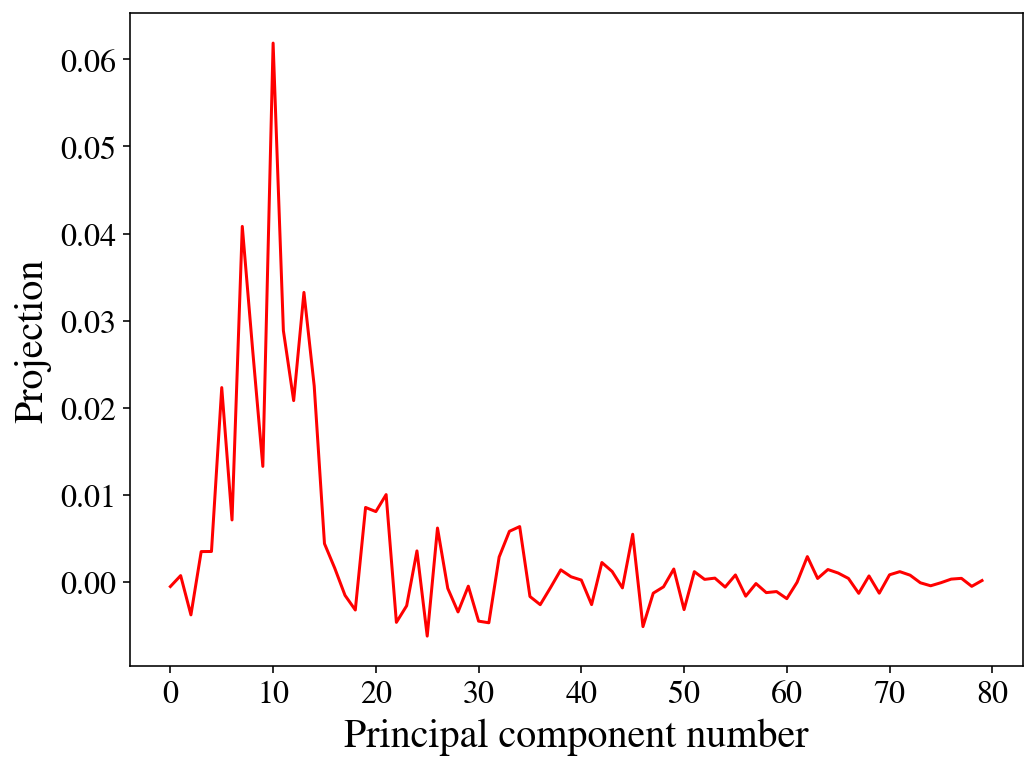

In [72]:
pca = PCA(data, fisher='m')
exem_matrix = pca.eigenvecs

fig,ax=plt.subplots()

projection = np.einsum("ij,j->i", exem_matrix, fun_mp(data.pivots))
ax.plot(np.arange(int(data.Npert)), projection, color="r")

ax.set_xlabel("Principal component number", fontsize=fsize)
ax.set_ylabel("Projection", fontsize=fsize)

#plt.legend()
plt.savefig("../results/H0_mode_no_prior_projection.png", dpi=300, bbox_inches='tight')
plt.show()